# 仿真实验记录册

> 用于记录光纤通信的仿真实验及特殊现象
> 日期：2025.1.27起

In [30]:
pip install numpy scipy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## SPM相旋估计与测量

当忽略光纤中的色散时，方程可以用归一化复包络表示为：
$$
\frac{\partial U}{\partial z}=\frac{je^{-\alpha z}}{L_{NL}}|U|^2U
$$

此时有解析解：
$$
U(z,T)=U(0,T)\exp(j\phi_{NL}(z,T))\\
\phi_{NL}(z,T)=|U|^2\frac{L_{eff}}{L_{NL}}\\
L_{eff}=\frac{1-e^{-\alpha z}}{\alpha}
$$

由此推测，给定光纤条件下，解调采样值的相旋与脉冲能量呈正相关。由于使用了基函数相关型解调，采样值的绝对值与脉冲能量的算术平方根成正比（均表示为星座图上的距离）

理想条件下单脉冲采样值满足
$$
s = \int_{-\infin}^{+\infin} U(0, \tau)\cdot U(0, \tau)\exp(j|U(0, \tau)|^2\frac{L_{eff}}{L_{NL}})d\tau
$$

这个积分难以进行解析求解或分析，但仿真结果表示其相角或与能量（即$\int_{-\infin}^{+\infin} U(0, \tau)^2d\tau$）的平方呈线性关系。

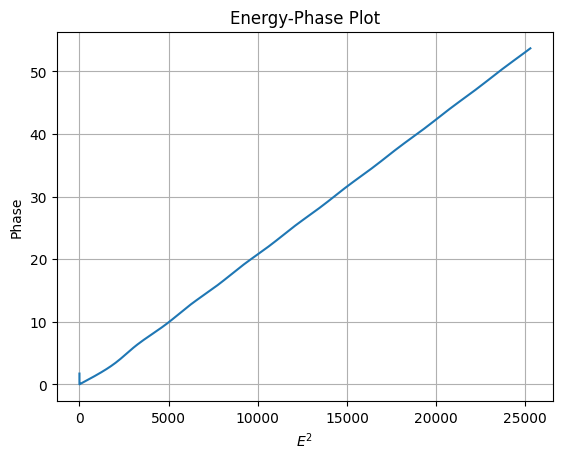

相关系数: 0.9999, P值: 4.4499e-281


In [31]:
from WaveGenerator import  BasicWaveGenerator
from SSFMSolver import  SSFMSolver
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 设置脉冲能量为0~N-1
N = 160
symbols = np.arange(N)

# 生成波形
gen = BasicWaveGenerator(bps=1e9, fs=2e12, basicWave='Gaussian', alpha='auto').setBits(symbols)\
        .modulation('PAM', maxEnergy=N/2, minEnergy=0, symbolCount=N).addZero(2)

# 仿真传输
solver = SSFMSolver(alphaDB=0, beta=[0], gamma=2, L=80, dz=0.5, title='SPM informed Phase Rotation')
solver.setInput(*gen.generate('omega'))

solver.propagate()
# solver.plot()

# 解调
dem = gen.demodulator()
dem.setSignal(solver.output).demodulate()
# dem.plotConstellation()

# 绘制能量与相旋关系
plt.figure(num='Energy-Phase')
# plt.plot(symbols**2, np.abs(dem.samples))
plt.plot(symbols**2, np.unwrap(np.angle(dem.samples)))
plt.xlabel('$E^2$')
plt.ylabel('Phase')
plt.title('Energy-Phase Plot')
plt.grid(True, 'both')
plt.grid(True, 'minor')
plt.show()

# 计算线性相关性
corr, p = pearsonr(symbols**2, np.unwrap(np.angle(dem.samples)))
print(f"相关系数: {corr:.4f}, P值: {p:.4e}")

## SPM脉冲峰值演化估计

在上面的实验中，偶然发现采样点的能量似乎呈现某种“趋于稳定的震荡过程”，依次猜测可能为贝塞尔函数、$y=a(1-e^{-bx})\cos(\omega x+\phi)+c$型函数等，均无法拟合到令人满意的结果，故作罢。


数据已成功保存到data.mat
Optimal parameters: a = -2.91, b = 1.00, c = 1.16, n=2.21
[[ 2.40833159e-01  9.03242021e-07 -9.52684471e-04  3.63720188e-03]
 [ 9.03242021e-07  1.71809357e-08  7.78179172e-08  3.95962129e-06]
 [-9.52684471e-04  7.78179172e-08  4.02823867e-04  1.77823120e-04]
 [ 3.63720188e-03  3.95962129e-06  1.77823120e-04  2.13746774e-02]]


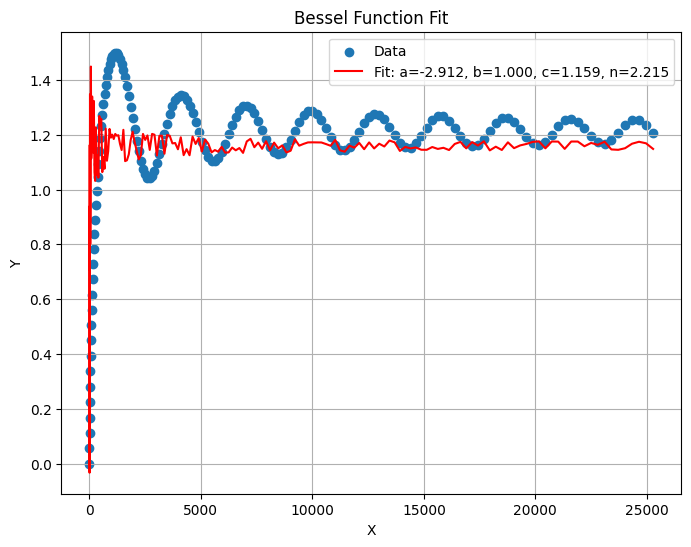

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv  # 贝塞尔函数
from scipy.optimize import curve_fit
from scipy.io import savemat

# 数据
x_data = symbols**2
y_data = np.abs(dem.samples)

# 将NumPy数组保存为MAT文件
savemat('amplitude.mat', {'x': x_data, 'y': y_data})

print("数据已成功保存到data.mat")

# 拟合函数，a和b是待确定的参数
def func(x, a, b, c, n):
    return a * jv(n, b * x) + c

popt, pcov = curve_fit(func, x_data, y_data)

# popt现在包含最优参数估计
print("Optimal parameters: a = {:.2f}, b = {:.2f}, c = {:.2f}, n={:.2f}".format(*popt))
print(pcov)

# 绘制图像
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data')  # 原始数据点
plt.plot(x_data, func(x_data, *popt), 'r-', label='Fit: a=%5.3f, b=%5.3f, c=%5.3f, n=%5.3f' % tuple(popt))
# args=(-1, 0.2, 1)
# plt.plot(x_data, func(x_data, *args), 'g-', label='Fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(args))

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bessel Function Fit')
plt.legend()
plt.grid(True, 'both')
plt.show()



## SSFM仿真的能量计算原理

对于实高斯脉冲
$$s(t)=Ae^{-(t/T_0)^2}$$
有两种方式表征脉冲的能量，一种为$A^2$，一种为$\int_{-\infty}^{\infty}s^2(t)dt=A^2T_0\sqrt{\pi}$。

为了探究两种方式哪个真正在SSFM计算中其作用，我们只需要探究$T_0$的作用。因此，只需要使两个峰值相同、宽度不同的脉冲通过相同的、仅有非线性效应的光纤，计算其符号的相旋即可。

实验代码及结果如下所示。数据表明，对于星座图中的坐标点而言，两种能量表示方式是等价的，即正确对应解调时脉宽不影响对脉冲能量的度量。

In [33]:
from WaveGenerator import BasicWaveGenerator
from SSFMSolver import SSFMSolver
import numpy as np
import matplotlib.pyplot as plt

# 预先准备发射器、求解器、接收机
gen = BasicWaveGenerator(bps=1e9, fs=5e12, basicWave='Gaussian', alpha=np.pi*2e-11).setBits(1)\
        .addZero(2).modulation('OOK', minEnergy=0, maxEnergy=1)
fiber = SSFMSolver(alphaDB=0, beta=[0], gamma=2, L=100, dz=0.5, title='Optical Fiber')
gen.generate()
dem = gen.demodulator()

# 生成两组波形
wave1, t, w = gen.generate(freqType='omega')
gen.info()
wave2 = gen.setBasicWave('Gaussian', np.pi*2e-10).generate(freqType='omega')[0]
gen.info()
wave2 *= np.max(np.abs(wave1)) / np.max(np.abs(wave2))

# 分别进行传输
output1 = fiber.setInput(wave1, t, w).propagate()
output2 = fiber.setInput(wave2, t, w).propagate()

# 计算符号相旋
rotate1 = np.angle(dem.setSignal(output1).demodulate().samples)[0]
dem = gen.demodulator()
rotate2 = np.angle(dem.setSignal(output2).demodulate().samples)[0]
print(f'两脉冲最大相旋分别为{rotate1:.3f}与{rotate2:.3f}')




bps: 1.00e+09
fs: 5.00e+12Hz
Symbol Period: 1000.00ps
basicWave: Gaussian
Half width: 20.00ps
bps: 1.00e+09
fs: 5.00e+12Hz
Symbol Period: 1000.00ps
basicWave: Gaussian
Half width: 200.00ps
两脉冲最大相旋分别为1.141与1.141


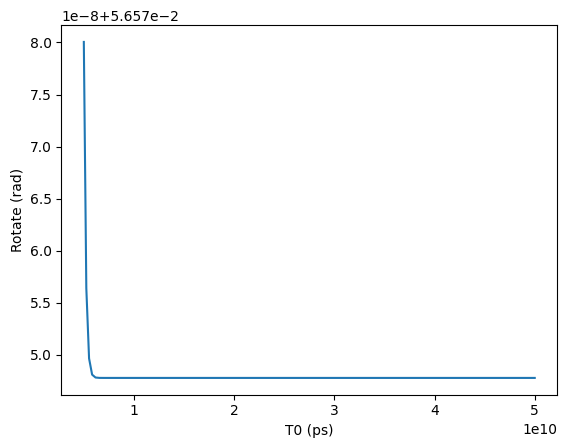

In [34]:
N = 20
widths = np.linspace(2e-11, 2e-10, N)
def calcRotate(T0):
    gen.setBasicWave('Gaussian', alpha=T0*np.pi).generate('omega')
    wave, t, w = gen.getWave('omega')
    wave /= np.max(np.abs(wave)) * 50
    output = fiber.setInput(wave, t, w).propagate()
    dem = gen.demodulator()
    dem.setSignal(output).demodulate()
    return np.angle(dem.samples[0])
    # dem = gen.demodulator()
    # dem.setSignal(fiber.setInput(*gen.getWave('omega')).propagate())
    # return np.angle(dem.demodulate().samples[0])

rotates = np.array([calcRotate(T0) for T0 in widths])
plt.figure()
plt.plot(1/widths, rotates)
plt.xlabel('T0 (ps)')
plt.ylabel('Rotate (rad)')
plt.show()
